<a href="https://colab.research.google.com/github/shabnamsattar/Human-Data-Analysis/blob/main/chestMNIST/chestMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import os
import random
import time
import pickle
import zipfile
import logging
import requests
import psutil

import math
import pickle
import time

import cv2
import numpy as np
#from numpy.random import default_rng
import matplotlib.pyplot as plt
import pandas as pd
from PIL import ImageFont
from tqdm import tqdm
from skimage.measure import label
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import holoviews as hv
from holoviews import opts

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, Input, Conv2D, BatchNormalization, Dense, ReLU, concatenate, Lambda
from tensorflow.keras.models import load_model, clone_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

# Uploading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path1 = '/content/drive/MyDrive/chestMNIST/chestmnist_64.npz'
path2 = '/content/drive/MyDrive/chestMNIST/chestmnist_128.npz'
path3 = '/content/drive/MyDrive/chestMNIST/chestmnist_224.npz'

In [ ]:
rng = np.random.default_rng(42)
percentage = 0.01

def subsample(imgs, labels, pct=percentage):
    n = imgs.shape[0]
    m = int(n * pct)
    idx = rng.choice(n, size=m, replace=False)
    return imgs[idx], labels[idx]

## ChestMNIST_64

In [ ]:
data_64 = np.load(path1, mmap_mode="r")

train_images_64 = data_64["train_images"]
train_labels_64 = data_64["train_labels"]
val_images_64   = data_64["val_images"]
val_labels_64   = data_64["val_labels"]
test_images_64  = data_64["test_images"]
test_labels_64  = data_64["test_labels"]


In [ ]:
train_images_64, train_labels_64 = subsample(train_images_64, train_labels_64)
val_images_64,   val_labels_64   = subsample(val_images_64,   val_labels_64)
test_images_64,  test_labels_64  = subsample(test_images_64,  test_labels_64)


## ChestMNIST_128

In [ ]:
data_128 = np.load(path2, mmap_mode="r")

train_images_128 = data_128["train_images"]
train_labels_128 = data_128["train_labels"]
val_images_128   = data_128["val_images"]
val_labels_128   = data_128["val_labels"]
test_images_128  = data_128["test_images"]
test_labels_128  = data_128["test_labels"]


In [ ]:
train_images_128, train_labels_128 = subsample(train_images_128, train_labels_128)
val_images_128,   val_labels_128   = subsample(val_images_128,   val_labels_128)
test_images_128,  test_labels_128  = subsample(test_images_128,  test_labels_128)


## ChestMNIST_224

In [ ]:
data_224 = np.load(path3, mmap_mode="r")

train_images_224 = data_224["train_images"]
train_labels_224 = data_224["train_labels"]
val_images_224   = data_224["val_images"]
val_labels_224   = data_224["val_labels"]
test_images_224  = data_224["test_images"]
test_labels_224  = data_224["test_labels"]


In [ ]:
train_images_224, train_labels_224 = subsample(train_images_224, train_labels_224)
val_images_224,   val_labels_224   = subsample(val_images_224,   val_labels_224)
test_images_224,  test_labels_224  = subsample(test_images_224,  test_labels_224)


# Data Visualization

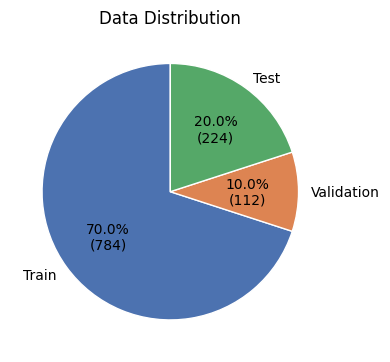

In [ ]:
counts = [len(train_images_64), len(val_images_64), len(test_images_64)]
labels = ['Train', 'Validation', 'Test']


total = sum(counts)
sizes = [c / total * 100 for c in counts]


# Custom autopct to show percent + count
def make_autopct(values):
    def autopct(pct):
        absolute = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({absolute})"
    return autopct

# Plot
plt.figure(figsize=(4,4))
plt.pie(
    sizes,
    labels= labels,
    autopct=make_autopct(counts),
    startangle=90,
    colors = ['#4C72B0','#DD8452','#55A868'],
    wedgeprops=dict(edgecolor='white', linewidth=1)
)
plt.title('Data Distribution')
plt.tight_layout()
plt.show()


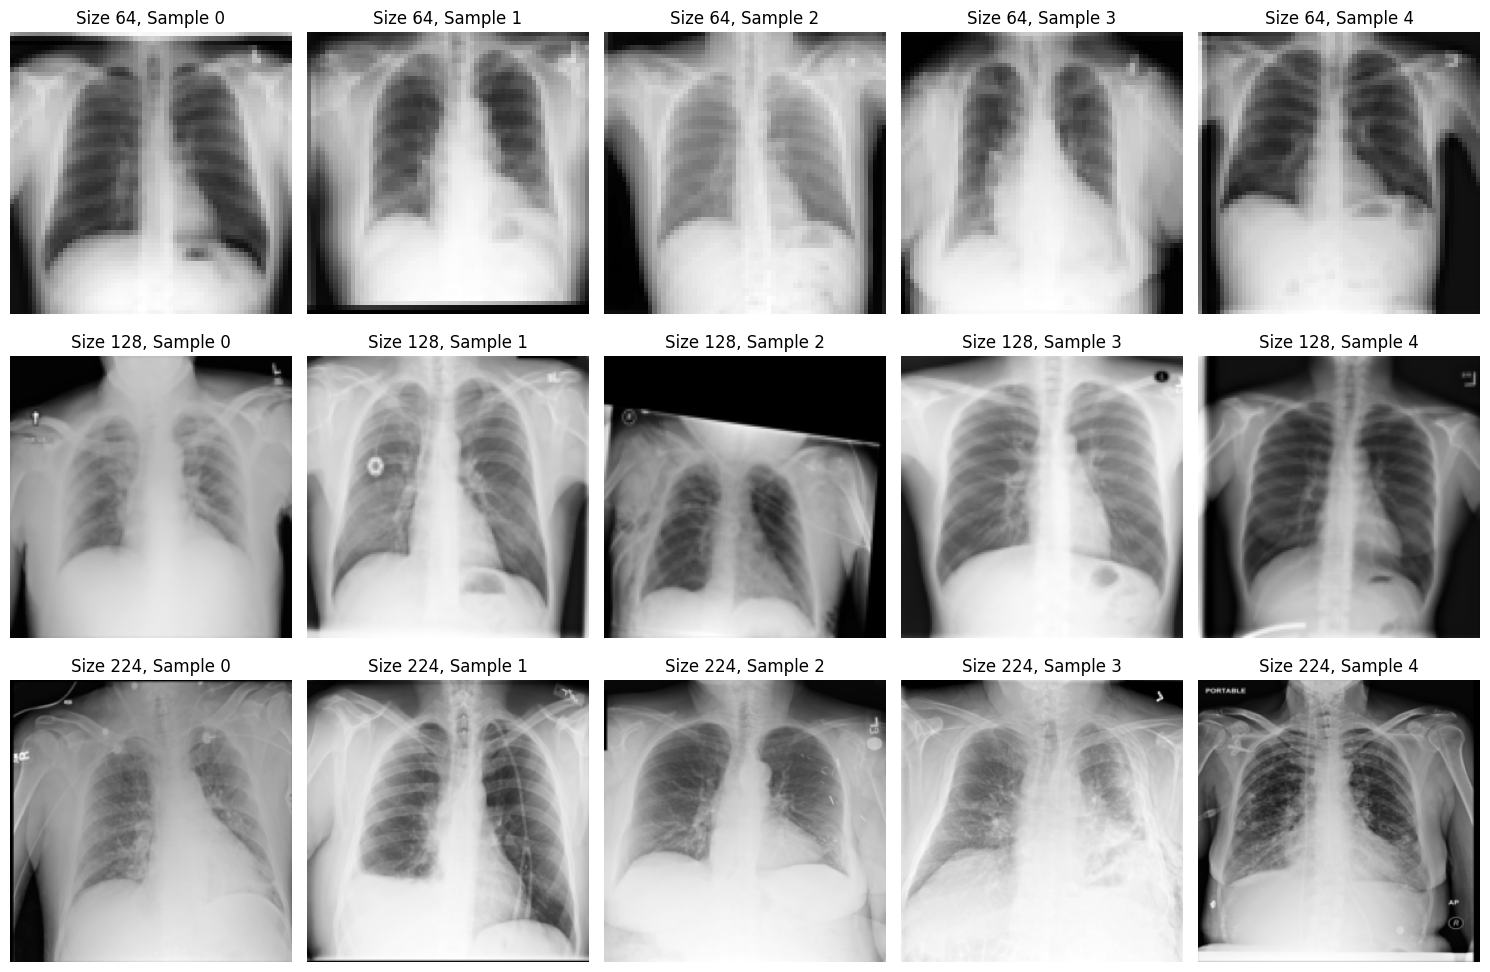

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
sizes = [64, 128, 224]
sets = (train_images_64, train_images_128, train_images_224)

for i, (size, imgs) in enumerate(zip(sizes, sets)):
    for j in range(5):
        ax = axes[i, j]
        ax.imshow(imgs[j], cmap='gray')
        ax.axis('off')
        ax.set_title(f"Size {size}, Sample {j}")

plt.tight_layout()
plt.show()


# Data Preprocessing

In [ ]:
# Create an instance of ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255
)

datagen_val = ImageDataGenerator(rescale=1./255)

# Custom generator for multi-label data
def data_generator(images, labels, batch_size, datagen):
    while True:
        indices = np.arange(len(images))
        #np.random.shuffle(indices)

        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            batch_indices = indices[start:end]
            batch_images = images[batch_indices]
            batch_labels = labels[batch_indices]

            augmented_images = []
            for img in batch_images:
                # Apply augmentations
                img = np.expand_dims(img, axis=-1)
                augmented = datagen.random_transform(img)
                augmented_images.append(augmented)

            # Convert to numpy arrays
            augmented_images = np.array(augmented_images)
            batch_labels = np.array(batch_labels)

            yield augmented_images, batch_labels



In [ ]:
batch_size = 32
train_generator_64 = data_generator(train_images_64, train_labels_64, batch_size, datagen)
val_generator_64 = data_generator(val_images_64, val_labels_64, batch_size, datagen_val)
test_generator_64 = data_generator(test_images_64, test_labels_64, batch_size, datagen_val)

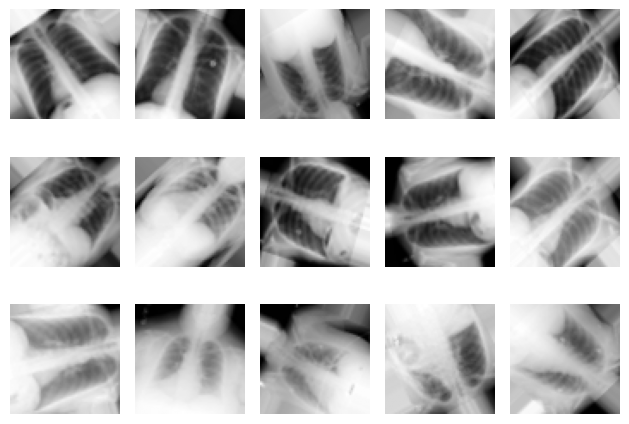

In [ ]:
def visualize_augmented_images(generator, num_images=5):
    plt.figure()
    for i in range(num_images):
        img, label = next(generator)
        ax = plt.subplot(3,5, i + 1)
        ax.imshow(img[0].reshape(64, 64), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


visualize_augmented_images(train_generator_64, num_images=15)

In [ ]:
labels_dict = {
    'hernia': [0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    'pleural': [0,0,0,0,0,0,0,0,0,0,0,0,1,0],
    'fibrosis': [0,0,0,0,0,0,0,0,0,0,0,1,0,0],
    'emphysema': [0,0,0,0,0,0,0,0,0,0,1,0,0,0],
    'edema': [0,0,0,0,0,0,0,0,0,1,0,0,0,0],
    'consolidation': [0,0,0,0,0,0,0,0,1,0,0,0,0,0],
    'pneumothorax': [0,0,0,0,0,0,0,1,0,0,0,0,0,0],
    'pneumonia':[0,0,0,0,0,0,1,0,0,0,0,0,0,0],
    'nodule': [0,0,0,0,0,1,0,0,0,0,0,0,0,0],
    'mass': [0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    "infiltration": [0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    'effusion': [0,0,1,0,0,0,0,0,0,0,0,0,0,0],
    'cardiomegaly': [0,1,0,0,0,0,0,0,0,0,0,0,0,0],
    'atelectasis': [1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'normal': [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
}

In [ ]:
def sum_of_columns(labels):
    if isinstance(labels, list):
      labels = np.array(labels)
    return np.sum(labels, axis=0)

train_sums = sum_of_columns(train_labels_64)
val_sums = sum_of_columns(val_labels_64)
test_sums = sum_of_columns(test_labels_64)

print("Train label sums:", train_sums)
print("Validation label sums:", val_sums)
print("Test label sums:", test_sums)

Train label sums: [ 66  22  89 121  19  46  13  46  36  13  24   3  14   0]
Validation label sums: [12  3 11 21 11  4  1  5  2  6  2  0  0  0]
Test label sums: [21  2 23 28 11 12  2 11  9  2  4  5  5  0]


In [ ]:
train_sums+val_sums+test_sums

array([ 99,  27, 123, 170,  41,  62,  16,  62,  47,  21,  30,   8,  19,
         0], dtype=uint64)

In [ ]:
def count_all_zeros(data):
    count = 0
    for row in data:
        if np.all(row == 0):
            count += 1
    return count

train_zeros = count_all_zeros(train_labels_64)
val_zeros = count_all_zeros(val_labels_64)
test_zeros = count_all_zeros(test_labels_64)

print(f"Number of rows with all zeros in training data: {train_zeros}")
print(f"Number of rows with all zeros in validation data: {val_zeros}")
print(f"Number of rows with all zeros in test data: {test_zeros}")

total_zeros = train_zeros + val_zeros + test_zeros
print(f"Total number of rows with all zeros: {total_zeros}")

Number of rows with all zeros in training data: 446
Number of rows with all zeros in validation data: 59
Number of rows with all zeros in test data: 132
Total number of rows with all zeros: 637


In [ ]:
data = [ 99,  27, 123, 170,  41,  62,  16,  62,  47,  21,  30,   8,  19,
         0, 637]
labels = ['atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass', 'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema', 'emphysema', 'fibrosis', 'pleural_thickening', 'hernia', 'No Finding']

total_count = len(train_images_64)+len(val_images_64)+len(test_images_64)
percentages = [(count / total_count) * 100 for count in data]

df = pd.DataFrame({'Label': labels, 'Count': data, 'Percentage': [f'{p:.2f}' for p in percentages]})

styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df = styled_df.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': '', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
])
display(styled_df)

,Label,Count,Percentage
0,atelectasis,99,8.84
1,cardiomegaly,27,2.41
2,effusion,123,10.98
3,infiltration,170,15.18
4,mass,41,3.66
5,nodule,62,5.54
6,pneumonia,16,1.43
7,pneumothorax,62,5.54
8,consolidation,47,4.20
9,edema,21,1.88


In [ ]:
all_labels = np.concatenate([train_labels_64, val_labels_64, test_labels_64])
n_classes = all_labels.shape[1]

co_occurrence_matrix = np.zeros((n_classes, n_classes), dtype=int)

# Calculate co-occurrence counts
for i in range(n_classes):
    for j in range(n_classes):
        co_occurrence_matrix[i, j] = np.sum(all_labels[:, i] & all_labels[:, j])

print("Co-occurrence Matrix:")
print(co_occurrence_matrix)

Co-occurrence Matrix:
[[ 99   2  30  21   4   6   3   8  13   2   3   1   2   0]
 [  2  27   7   5   0   0   1   0   4   0   0   0   1   0]
 [ 30   7 123  25  10   5   5  13  14   8   4   0   5   0]
 [ 21   5  25 170   6  11   5   8   5   9   6   1   4   0]
 [  4   0  10   6  41   7   1   3   3   2   1   0   2   0]
 [  6   0   5  11   7  62   2   4   7   0   0   2   4   0]
 [  3   1   5   5   1   2  16   0   2   4   0   0   0   0]
 [  8   0  13   8   3   4   0  62   1   0  12   1   4   0]
 [ 13   4  14   5   3   7   2   1  47   2   2   1   0   0]
 [  2   0   8   9   2   0   4   0   2  21   1   0   0   0]
 [  3   0   4   6   1   0   0  12   2   1  30   0   3   0]
 [  1   0   0   1   0   2   0   1   1   0   0   8   1   0]
 [  2   1   5   4   2   4   0   4   0   0   3   1  19   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
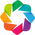

:Chord   [Source,Target]   (Value)

In [ ]:
hv.extension('bokeh')

labels = [
    "atelectasis", "cardiomegaly", "effusion", "infiltration", "mass",
    "nodule", "pneumonia", "pneumothorax", "consolidation", "edema",
    "emphysema", "fibrosis", "pleural_thickening", "hernia"
]

links = []
for i in range(len(labels)):
    for j in range(i + 1, len(labels)):  # Ensure i < j to remove duplicates
        value = co_occurrence_matrix[i, j] + co_occurrence_matrix[j, i]  # Combine both directions
        if value > 0:  # Only include non-zero connections
            links.append((labels[i], labels[j], value))

#DataFrame for links
df_links = pd.DataFrame(links, columns=["Source", "Target", "Value"])

chord = hv.Chord(df_links).opts(
    opts.Chord(
        labels='index',  \
        edge_color='Source',
        edge_cmap='Category20',
        node_color='index',
        node_cmap='Category20',
        node_size=15,
        width=600,
        height=600,
        title= " Disease Co-occurrence Diagram",
        label_text_font_size="10pt"
  )
)

hv.output(chord)

In [ ]:
class LogSumExpPooling2D(tf.keras.layers.Layer):
    def __init__(self, axis=(1, 2), **kwargs):
        super(LogSumExpPooling2D, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        max_val = tf.reduce_max(inputs, axis=self.axis, keepdims=True)
        logsumexp = tf.reduce_logsumexp(inputs - max_val, axis=self.axis, keepdims=False)
        return logsumexp + tf.squeeze(max_val, axis=self.axis)

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        for ax in sorted(self.axis, reverse=True):
            del output_shape[ax]
        return tuple(output_shape)

In [ ]:
def create_custom_cnn(input_shape, num_classes=14):

    K.clear_session()

    inputs = layers.Input(shape=input_shape)

    # First convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Third convolutional block
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Fourth convolutional block
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Fifth convolutional block
    x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # x = layers.Conv2DTranspose(1024, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Output layer for multi-label classification
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    # Define the model
    model = models.Model(inputs, outputs)
    return model

In [ ]:
def plot_training_history(history, moving_avg_window=2):

    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    keys = history.history.keys()
    metric_pairs = [(k, f"val_{k}") for k in keys if not k.startswith('val_') and f"val_{k}" in keys]

    # Determine the layout based on the number of metrics
    n_metrics = len(metric_pairs)
    nrows = (n_metrics + 1) // 2
    ncols = 2

    plt.figure(figsize=(16, 6 * nrows))

    for i, (train_metric, val_metric) in enumerate(metric_pairs, start=1):
        # Fetch metric values
        train_values = history.history[train_metric]
        val_values = history.history[val_metric]

        plt.subplot(nrows, ncols, i)

        # Plot moving average (if window size is greater than 1)
        if moving_avg_window > 1:
            train_smoothed = moving_average(train_values, moving_avg_window)
            val_smoothed = moving_average(val_values, moving_avg_window)

            # Adjust the x-axis to align the moving average with the original data
            epochs = range(len(train_smoothed))

            plt.plot(epochs, train_smoothed, color='blue', linewidth=2, label='Train (Smoothed)')
            plt.plot(epochs, val_smoothed, color='orange', linewidth=2, label='Validation (Smoothed)')


        plt.title(f"Model {train_metric.replace('_', ' ').capitalize()}")
        plt.xlabel('Epoch')
        plt.ylabel(train_metric.capitalize())
        plt.legend(loc='upper left')
        plt.grid(color='lightgray', linestyle='-', linewidth=0.25)

    plt.tight_layout()
    plt.show()

In [ ]:
import os, time, math, pickle, psutil, tensorflow as tf

def train_and_save_cnn(loss, batch_size, num_epochs, model,
                       train_generator, val_generator,
                       model_base):               # pass *base* path, no ext
    model.compile(optimizer='adam', loss=loss,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.AUC()])

    steps_per_epoch  = math.ceil(len(train_images_64) / batch_size)
    validation_steps = math.ceil(len(val_images_64) / batch_size)

    t0 = time.time()
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=num_epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        verbose=1)
    print(f"Training took {time.time()-t0:.1f}s")

    # ---------- save ----------
    model_file   = f'{model_base}.keras'
    history_file = f'{model_base}_history.pkl'
    os.makedirs(os.path.dirname(model_file), exist_ok=True)

    model.save(model_file)
    pickle.dump(history.history, open(history_file, 'wb'))

    # ---------- memory usage ----------
    proc = psutil.Process()
    mem_mb = proc.memory_info().rss / 1_048_576   # bytes → MiB
    print(f"Current memory usage: {mem_mb:.2f} MB")

    print("saved:", model_file)
    print("saved:", history_file)
    return model, history


In [ ]:
@tf.keras.utils.register_keras_serializable()
def weighted_cross_entropy_loss(y_true, y_pred):

    # Calculate the number of positive (1s) and negative (0s) labels in the batch
    positive_count = tf.reduce_sum(y_true, axis=0) + 1e-7  # Add small constant to avoid division by zero
    negative_count = tf.reduce_sum(1 - y_true, axis=0) + 1e-7

    # Compute the balancing factors for positive and negative samples
    beta_p = (positive_count + negative_count) / positive_count
    beta_n = (positive_count + negative_count) / negative_count

    # Compute the positive and negative parts of the loss
    positive_loss = -beta_p * y_true * tf.math.log(y_pred + 1e-7)
    negative_loss = -beta_n * (1 - y_true) * tf.math.log(1 - y_pred + 1e-7)

    # Combine the positive and negative losses
    loss = tf.reduce_mean(positive_loss + negative_loss)

    return loss

In [ ]:
train_generator = data_generator(train_images_64, train_labels_64, batch_size, datagen)
val_generator = data_generator(val_images_64, val_labels_64, batch_size, datagen_val)
test_generator = data_generator(test_images_64, test_labels_64, batch_size, datagen_val)

5555555555555555555555555555555555555555555555555555555555555555555555555

In [ ]:
# Runtime ▸ Restart and run this cell first
import math, time, os, pickle, psutil, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from google.colab import drive

drive.mount('/content/drive', force_remount=True)          # <‑‑ make Drive visible


Mounted at /content/drive


In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/simple_model_BCE'  # no ext

simple_model_BCE, simple_hist = train_and_save_cnn(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=15,
    model=create_custom_cnn((64, 64, 1), num_classes=14),
    train_generator=train_generator,
    val_generator=val_generator,
    model_base=model_base
)


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - auc: 0.5156 - binary_accuracy: 0.5276 - loss: 1.0081 - val_auc: 0.4628 - val_binary_accuracy: 0.5547 - val_loss: 2.7519
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - auc: 0.5378 - binary_accuracy: 0.7615 - loss: 0.6252 - val_auc: 0.4483 - val_binary_accuracy: 0.7835 - val_loss: 0.5664
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - auc: 0.6390 - binary_accuracy: 0.9140 - loss: 0.5431 - val_auc: 0.5003 - val_binary_accuracy: 0.7377 - val_loss: 0.5388
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - auc: 0.6739 - binary_accuracy: 0.9452 - loss: 0.4378 - val_auc: 0.4216 - val_binary_accuracy: 0.9475 - val_loss: 0.2676
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - auc: 0.7122 - binary_accuracy: 0.9489 - loss: 0.3226 - val_auc: 0.5812 - val_binary_accuracy: 0.9475 - val_loss: 0.2437
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - auc: 0.7571 - binary_accuracy: 0.9529 - loss: 0.2348 - val_auc: 0.5140 - val_binary_accu

In [ ]:
plot_training_history(simple_model_BCE_history)

In [ ]:
!ls -lh "/content/drive/MyDrive/chestMNIST" | grep "simple_model_BCE"

-rw------- 1 root root  924 May  5 17:27 simple_model_BCE_history.pkl
-rw------- 1 root root  73M May  5 17:27 simple_model_BCE.keras


In [ ]:
from tensorflow import keras   # import again if you restarted

model_path   = '/content/drive/MyDrive/chestMNIST/simple_model_BCE.keras'
history_path = '/content/drive/MyDrive/chestMNIST/simple_model_BCE_history.pkl'

simple_model_BCE = keras.models.load_model(model_path)           # ← works
simple_hist      = pickle.load(open(history_path, 'rb'))


55555555555555555555555

In [ ]:
batch_size = 64
train_generator = data_generator(train_images_64, train_labels_64, batch_size, datagen)
val_generator = data_generator(val_images_64, val_labels_64, batch_size, datagen_val)
test_generator = data_generator(test_images_64, test_labels_64, batch_size, datagen_val)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - auc: 0.7070 - binary_accuracy: 0.9556 - loss: 0.1748
Test Loss: 0.16651926934719086
Test AUC: 0.7235641479492188
Test Binary Accuracy: 0.957217276096344
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Classification Report:
                     precision    recall  f1-score   support

       atelectasis       0.15      0.68      0.24        19
      cardiomegaly       0.00      0.00      0.00         1
          effusion       0.15      0.36      0.21        22
      infiltration       0.22      0.48      0.30        25
              mass       0.04      0.86      0.08         7
            nodule       0.07      0.22      0.11         9
         pneumonia       0.00      0.00      0.00         2
      pneumothorax       0.05      0.25      0.08         8
     consolidation       0.09      0.50      0.15         8
             edema       0.00      0.00      0.00         2
         emphysema       0.00      0.00      0.00         3
          fibrosis       0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_divi

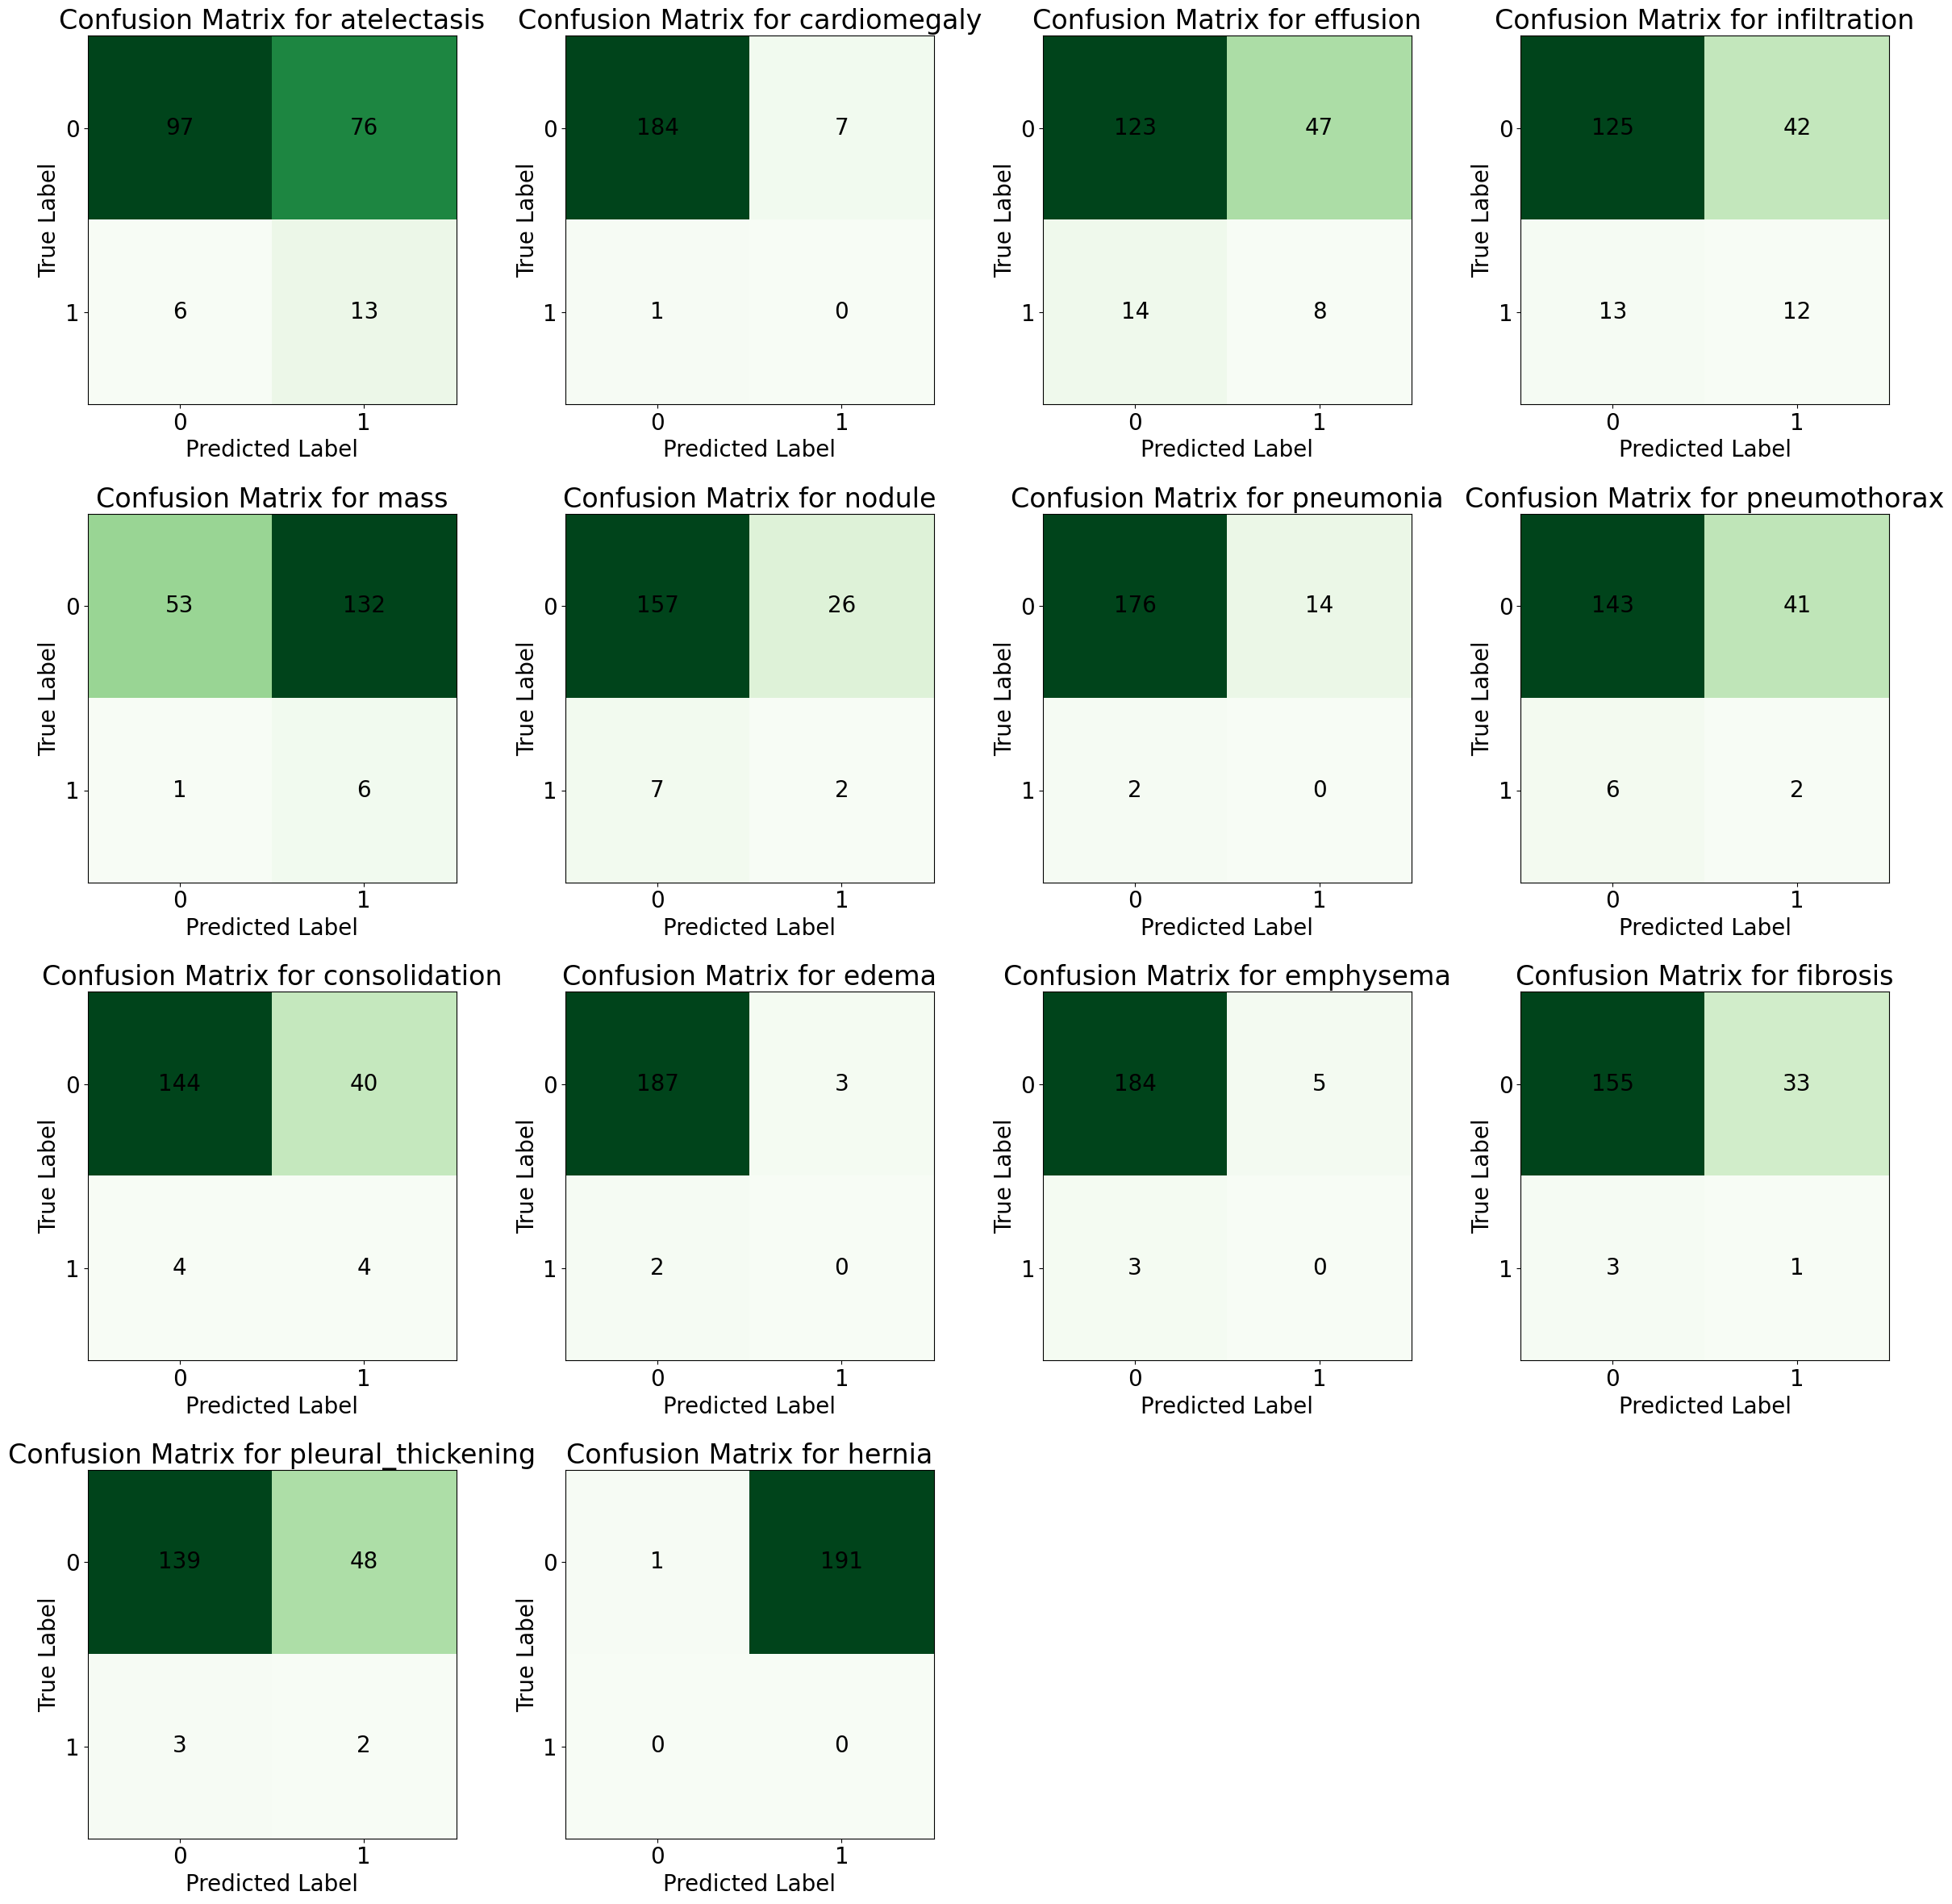

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve

plt.rcParams.update({'font.size': 20})

batch_size=64
steps_per_epoch = len(test_images_64) // batch_size
evaluation = simple_model_BCE.evaluate(test_generator, steps=steps_per_epoch)

class_labels = [
    'atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass',
    'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema',
    'emphysema', 'fibrosis', 'pleural_thickening', 'hernia'
]

# Print evaluation metrics
print("Test Loss:", evaluation[0])
print("Test AUC:", evaluation[2])
print("Test Binary Accuracy:", evaluation[1])

y_probs = simple_model_BCE.predict(test_generator, steps=steps_per_epoch)
y_true = test_labels_64

corrected_len = len(y_probs)

# Tune threshold per class using precision-recall curve
optimal_thresholds = []
for i in range(len(class_labels)):
    precision, recall, thresholds = precision_recall_curve(y_true[:corrected_len, i], y_probs[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)  # Avoid divide-by-zero
    optimal_thresholds.append(thresholds[np.argmax(f1_scores)])  # Best F1-score threshold

# Generate predictions using the test generator
y_pred = (y_probs > np.array(optimal_thresholds)).astype(int)

# Print classification report (averaged for multi-label data)
print("Classification Report:\n", classification_report(y_true[:corrected_len], y_pred, target_names=class_labels))  # Pass class_labels as target_names

# Generate confusion matrices for each class (multi-label)
confusion_matrices = multilabel_confusion_matrix(y_true[:corrected_len], y_pred)

# Plot confusion matrices for individual classes
fig, axes = plt.subplots(4, 4, figsize=(24, 24))
axes = axes.flatten()

for idx, (cm, label) in enumerate(zip(confusion_matrices, class_labels)):
    ax = axes[idx]
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    ax.set_title(f"Confusion Matrix for {label}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    tick_marks = [0, 1]
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    # Add values to the confusion matrix
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

# Remove unused subplots
for idx in range(len(class_labels), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

# Exact Match Ratio (Strict accuracy)
exact_match_ratio = accuracy_score(y_true[:corrected_len], y_pred)

# Hamming Loss (fraction of labels incorrectly classified)
hamming = hamming_loss(y_true[:corrected_len], y_pred)

# F1-scores
macro_f1 = f1_score(y_true[:corrected_len], y_pred, average='macro')  # Class-wise F1-score
micro_f1 = f1_score(y_true[:corrected_len], y_pred, average='micro')  # Aggregated F1-score

print(f"Exact Match Ratio: {exact_match_ratio:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Micro F1-score: {micro_f1:.4f}")


Exact Match Ratio: 0.0000
Hamming Loss: 0.2865
Macro F1-score: 0.0929
Micro F1-score: 0.1149


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


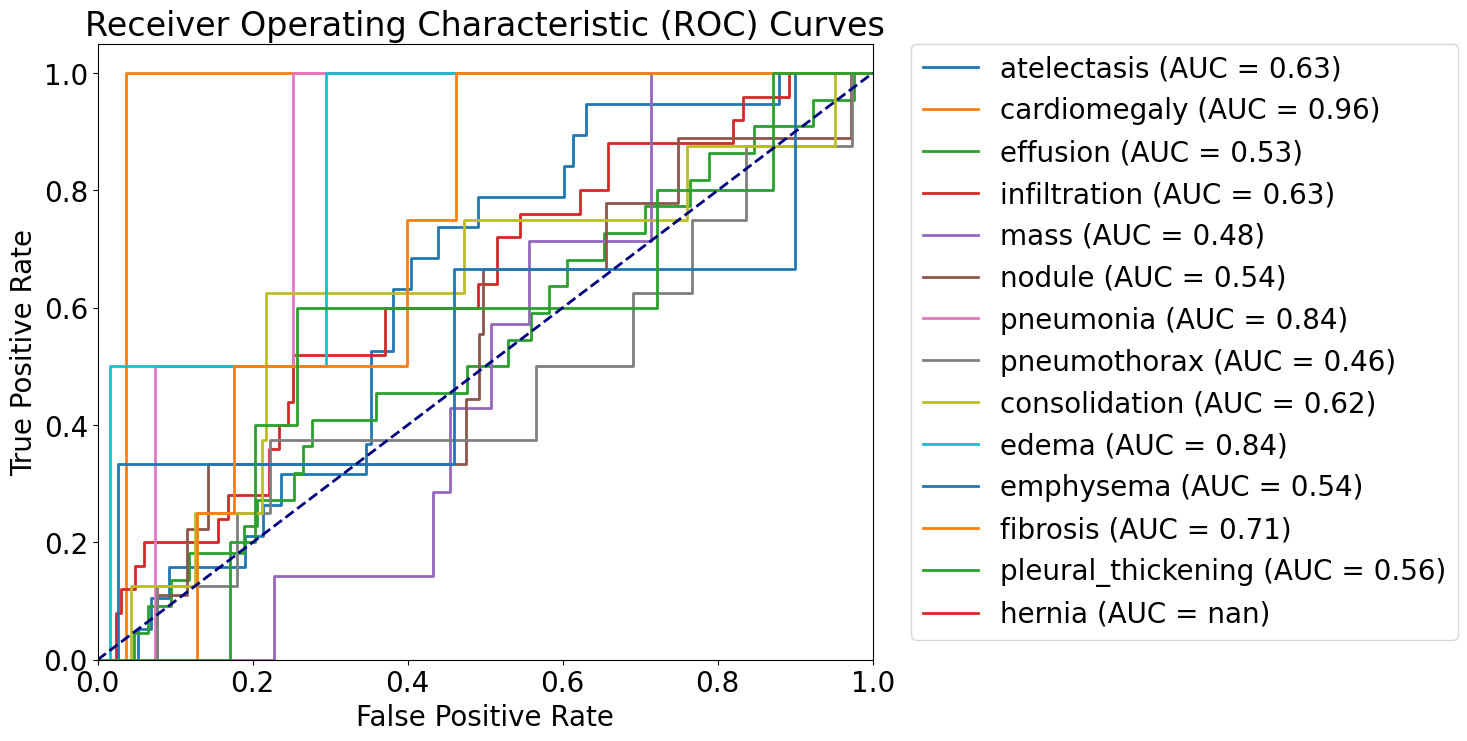

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:corrected_len, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')

# Place legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()


In [ ]:
train_generator = data_generator(train_images_64, train_labels_64, batch_size, datagen)
val_generator = data_generator(val_images_64, val_labels_64, batch_size, datagen_val)
test_generator = data_generator(test_images_64, test_labels_64, batch_size, datagen_val)

In [ ]:
simple_model_WCE, simple_model_WCE_history = train_and_save_cnn(
    loss = weighted_cross_entropy_loss,
    batch_size = 64,
    num_epochs = 2,
    model = create_custom_cnn(input_shape=(64, 64, 1), num_classes=14),
    train_generator = train_generator,
    val_generator = val_generator,
    model_base = 'simple_model_WCE'
)

In [ ]:
batch_size = 64
train_generator = data_generator(train_images_64, train_labels_64, batch_size, datagen)
val_generator = data_generator(val_images_64, val_labels_64, batch_size, datagen_val)
test_generator = data_generator(test_images_64, test_labels_64, batch_size, datagen_val)

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve


plt.rcParams.update({'font.size': 20})

batch_size=64
steps_per_epoch = len(test_images_64) // batch_size
evaluation = simple_model_WCE.evaluate(test_generator, steps=steps_per_epoch)

class_labels = [
    'atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass',
    'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema',
    'emphysema', 'fibrosis', 'pleural_thickening', 'hernia'
]

# Print evaluation metrics
print("Test Loss:", evaluation[0])
print("Test AUC:", evaluation[2])
print("Test Binary Accuracy:", evaluation[1])

# Generate raw predictions
y_probs = simple_model_WCE.predict(test_generator, steps=steps_per_epoch)
y_true = test_labels_64  # True labels (multi-label ground truth)

corrected_len = len(y_probs)

# Tune threshold per class using precision-recall curve
optimal_thresholds = []
for i in range(len(class_labels)):
    precision, recall, thresholds = precision_recall_curve(y_true[:corrected_len, i], y_probs[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)  # Avoid divide-by-zero
    optimal_thresholds.append(thresholds[np.argmax(f1_scores)])  # Best F1-score threshold

# Generate predictions using the test generator
y_pred = (y_probs > np.array(optimal_thresholds)).astype(int)

# Print classification report (averaged for multi-label data)
print("Classification Report:\n", classification_report(y_true[:corrected_len], y_pred, target_names=class_labels))  # Pass class_labels as target_names

# Generate confusion matrices for each class (multi-label)
confusion_matrices = multilabel_confusion_matrix(y_true[:corrected_len], y_pred)

# Plot confusion matrices for individual classes
fig, axes = plt.subplots(4, 4, figsize=(24, 24))
axes = axes.flatten()

for idx, (cm, label) in enumerate(zip(confusion_matrices, class_labels)):
    ax = axes[idx]
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    ax.set_title(f"Confusion Matrix for {label}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    tick_marks = [0, 1]
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    # Add values to the confusion matrix
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

# Remove unused subplots
for idx in range(len(class_labels), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

# Exact Match Ratio (Strict accuracy)
exact_match_ratio = accuracy_score(y_true[:corrected_len], y_pred)

# Hamming Loss (fraction of labels incorrectly classified)
hamming = hamming_loss(y_true[:corrected_len], y_pred)

# F1-scores
macro_f1 = f1_score(y_true[:corrected_len], y_pred, average='macro')  # Class-wise F1-score
micro_f1 = f1_score(y_true[:corrected_len], y_pred, average='micro')  # Aggregated F1-score

print(f"Exact Match Ratio: {exact_match_ratio:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Micro F1-score: {micro_f1:.4f}")


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:corrected_len, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')

# Place legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()
